# Исследование объявлений о продаже квартир

**Цель данного исследования** — определить рыночную стоимость объектов недвижимости в Санкт-Петербурге и соседних населённых пунктах на основе анализа имеющихся данных о продаже квартир. 
**Задачи исследования**
- Загрузить и предобработать данные перед анализом.
- Провести исследовательский анализ данных, чтобы выявить основные факторы, влияющие на стоимость квартир.
- Определить параметры, которые оказывают значительное влияние на цену недвижимости, такие как удалённость от центра города, наличие парков и водоёмов, транспортная доступность и другие.
- Разработать рекомендации по использованию полученных результатов для улучшения оценки объектов недвижимости и повышения надежности сервиса.

### Загрузка данных и подготовка их к анализу

In [1]:
import matplotlib.pyplot as plt  #подключаем необходимые для работы библиотеки
import pandas as pd

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')


In [2]:
print(data.info()) #выводим основную информацию о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

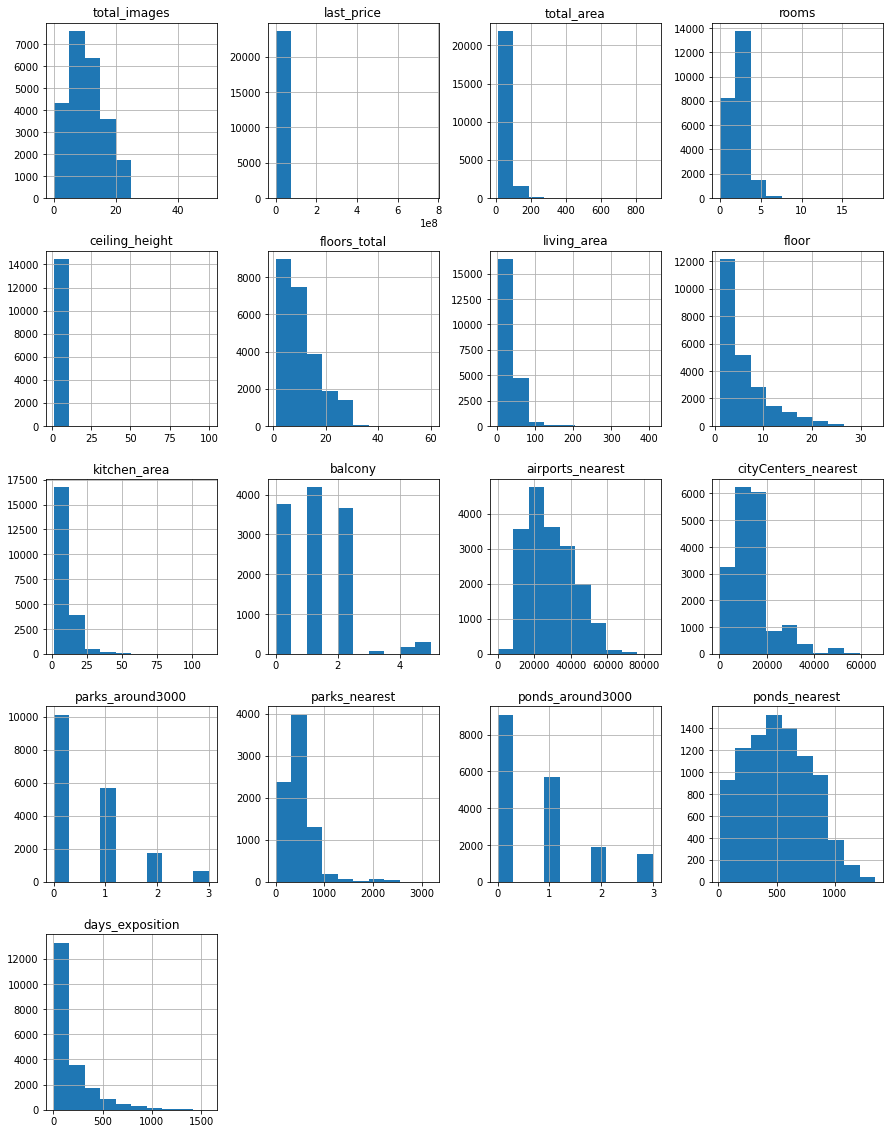

In [3]:
data.hist(figsize=(15, 20)) #строим гистограммы
plt.show()

На этапе получения данных выгружена таблица, получена общая информация о ней, а также построены гистограммы, глядя на которые можно уже подметить кое-какие особенности объявлений - большинство предложений имеют около 10 фотографий квартиры, в среднем 2 комнаты, у многих квартир отсутствуют водоемы по близости и т.д.


In [4]:
data.isna().sum() #проверяем наличие пропусков по столбцам

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
%%capture  
!pip install missingno

import missingno as msno #подключаем библиотеку для визуализации пропусков и скрываем отображение процесса установки


<AxesSubplot:>

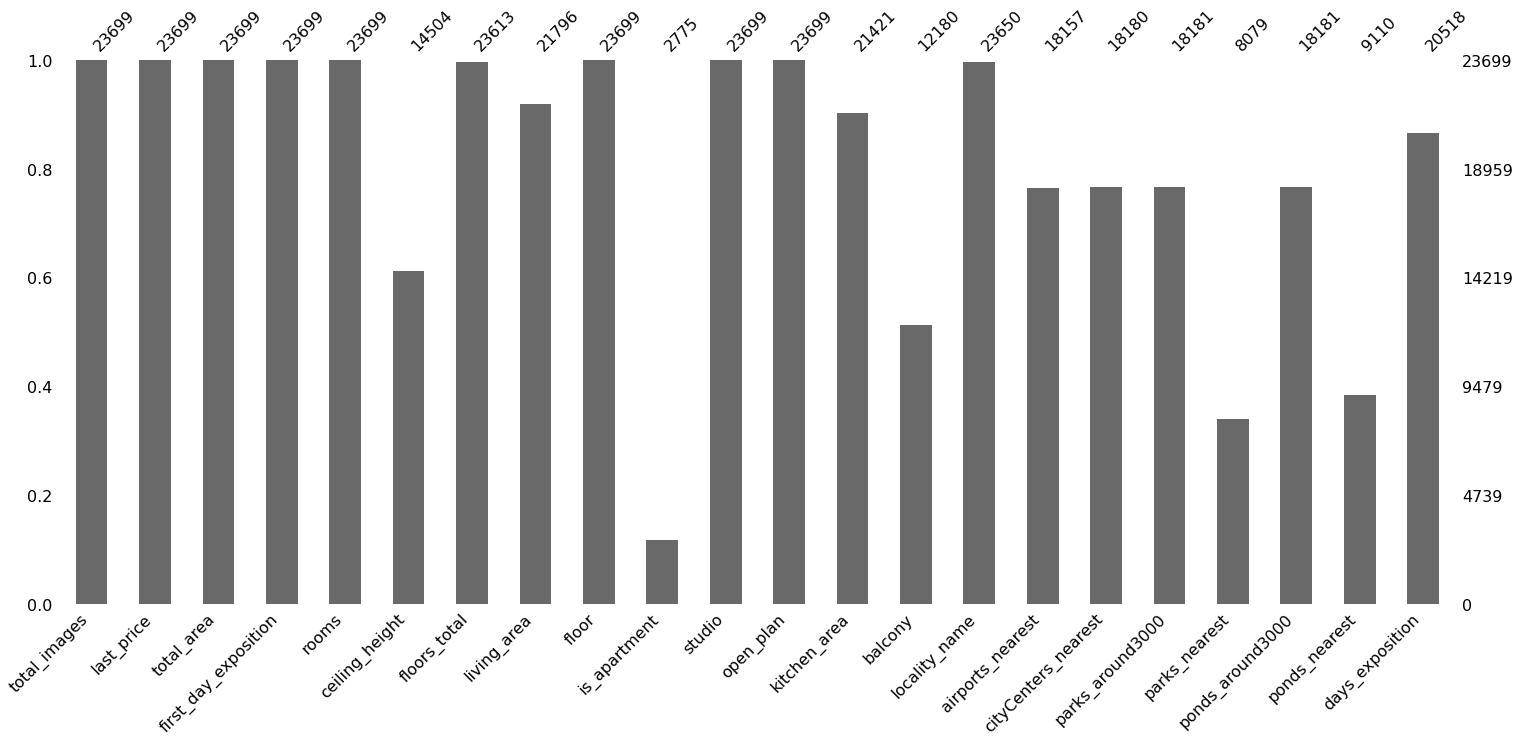

In [6]:
msno.bar(data) #визуализируем количество пропусков с помощью гистограммы

После построения гистограммы полноты значений по столбцам видно, что сильно проседают столбца с информацией "апартаменты", "парки рядом", "водоемы рядом". Столбцы с основной информацией о стоимости, площадях квартиры, этажности, время нахождения объявления на площадке заполнены хорошо, что не должно привести к дикомфорту во время анализа данных. 

In [7]:
for l in data['rooms'].unique():
    data.loc[(data['rooms'] == l) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == l), 'living_area'].median() #заменяем пропущенные значения в жилой площади медианными значениями жилой площади с таким же кол-вом комнат

In [8]:
data['balcony'] = data['balcony'].fillna(0) #заменяем отсутствующие значения балконов на 0, предполагая, что раз не указано кол-во балконов, значит их нету

In [9]:
data['parks_around3000'] = data['parks_around3000'].fillna(0) #с парками и водоемами поступаем также, как и с балконами
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

In [10]:
data.isna().sum() #проверяем сработали ли замены пропущенных значений

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропущенные значения обработаны там, где это логически возможно, т.к. в основном строительство типовое и все метражи (жилая площадь, кол-во комнат) +- соотносятся между собой. Расстояния до парков, водоемов и прочих объектов мы никак не можем предугадать, следовательно, эти значения заменить не получится. Также и с высотой потолков.
Прпоуски в данных обычно бывают по нескольким причинам: технические (проблема с серверами, неправильная выгрузка данных) и человеческий фактор (при заполнении анкеты забыл ответить на вопрос, либо сознательное укрытие фактов).

In [11]:
data['is_apartment'] = data['is_apartment'].astype(bool) #меняем типы данных там, где необходимо
data['parks_around3000'] = data['parks_around3000'].astype(int)
data['ponds_around3000'] = data['ponds_around3000'].astype(int)
data['balcony'] = data['balcony'].astype(int)

In [12]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') #приводим дату в единый формат


Тип данных преобразовывают для уменьшения объема таблицы, покольку int занимает меньше места, чем другие типы данных. Также, замена производится для возможности проведения математических операций и оптимизации данных.

In [13]:
data['locality_name'].nunique() #выводим количество уникальных значений

364

In [14]:
print(data['locality_name'].unique()) #получаем уникальные названия поселений

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

In [15]:
#создаем функцию для удаления префиксов в названиях населенных пунктов, выводим все в новый столбец 'name_delite_prefix'
def delite_prefixes(name): 
    if pd.isna(name):  
        return name 
    prefixes = ['посёлок', 'станции', 'поселок', 'деревня', 'городской посёлок','городской поселок', 'село', 'городского типа ', 'садовое товарищество ', 'садоводческое некоммерческое товарищество ', 'при железнодорожной станции ', 'Пансионат ', 'коттеджный', 'коттеджный', ' станции ', 'имени']
    for prefix in prefixes:
        if name.startswith(prefix):
            return name.replace(prefix, '', 1).strip()
    return name
data['name_delite_prefix'] = data['locality_name'].apply(delite_prefixes)

In [16]:
data['name_delite_prefix'].nunique() #выводим количество уникальных названий после удаления префиксов, 45 неявных дубликатов почищены

319

На этапе предобработки данных была получена информация о таблице, изменен тип данных там, где это необходимо, устранены неявные дубликаты, а также построенные гистограммы для каждого столбца для визупльной оценки имеющейся в таблице информации. 

### Добавление столбцов

In [17]:
data['metr_price'] = data['last_price'] / data['total_area'] #определяем стоимость квадратного метра
data['metr_price'] = data['metr_price'].round(2) #округляем стоимость до 2-ух знаков после запятой
print(data['metr_price'].head(5)) #проверяем полученный результат

0    120370.37
1     82920.79
2     92785.71
3    408176.10
4    100000.00
Name: metr_price, dtype: float64


In [18]:
data['week_day'] = data['first_day_exposition'].dt.dayofweek #создаем новый столбец с днем недели публикации
print(data['week_day'].head(5)) #проверяем созданный столбец

0    3
1    1
2    3
3    4
4    1
Name: week_day, dtype: int64


In [19]:
data['month_exposition'] = data['first_day_exposition'].dt.month #создаем новый столбец с месяцем публикации
print(data['month_exposition'].head(5)) #проверяем созданный столбец

0     3
1    12
2     8
3     7
4     6
Name: month_exposition, dtype: int64


In [20]:
data['year_exposition'] = data['first_day_exposition'].dt.year #создаем новый столбец с годом публикации
print(data['year_exposition'].head(5)) #проверяем созданный столбец

0    2019
1    2018
2    2015
3    2015
4    2018
Name: year_exposition, dtype: int64


In [21]:
#создаем функцию для категоризации этажа и применяем результат функции к новому столбцу 'floor_group'
#0 - первый, 1 - последний, 2 - другой
def floor_group(row): 
    if row['floor'] == 1:
        return '0'
    elif row['floor'] == row['floors_total']:
        return '1'
    else:
        return '2'
    
data['floor_group'] = data.apply(floor_group, axis=1)
data['floor_group'] = data['floor_group'].astype(int) #переводим формат значений столбца в числовой
print(data['floor_group'].head(5)) #проверяем созданный столбец


0    2
1    0
2    2
3    2
4    2
Name: floor_group, dtype: int64


In [22]:
data['cityCenters_km'] = data['cityCenters_nearest'] / 1000 #создаем новый столбец с расстоянием до центра города в км
data['cityCenters_km'] = round(data['cityCenters_km']) #округляем полученные значения до ближайшего целого числа
print(data['cityCenters_km'].head(5)) #проверяем созданный столбец

0    16.0
1    19.0
2    14.0
3     7.0
4     8.0
Name: cityCenters_km, dtype: float64


На данном этапе добавлены новые столбцы со значениями цены 1 квадратного метра, с днем, месяцем и годом публикации объявления, а также поделены этажи на группы (первый, последний, другой), что пригодится для дальнейшего анализа. 

### Исследовательский анализ данных

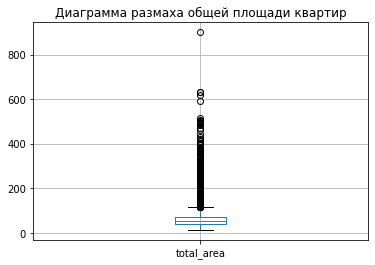

In [23]:
data.boxplot('total_area') #строим ящик с усами для определения выбросов для последующей "чистки"
plt.title('Диаграмма размаха общей площади квартир');

На диаграмме размаха видно, что межквартильный интервал находится в пределах примерно 10-130, всё, что выше - уже будет считаться выбросами. Поэтому, чтобы была возможность сразу построить красивую гистрограмму, с помощью более детального "ящика с усами" рассмотрим интересующие нас параметры - медиану, Q1, Q3.

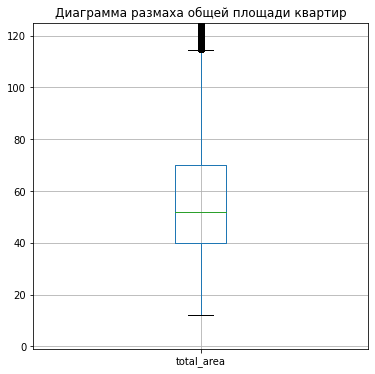

In [24]:
ta = data.boxplot('total_area', figsize=(6, 6))
ta.set_ylim(-1, 125)
plt.title('Диаграмма размаха общей площади квартир');

Из данной диаграммы размаха видно, что половина продаваемых квартир имеет общую площадь около 50 квадратных метров. Однако, на просторах объявлений достаточно как и более просторных квартир, так и совсем маленьких.

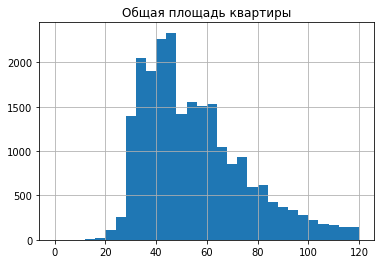

In [25]:
data['total_area'].hist(range=(0, 120), bins=30)
plt.title('Общая площадь квартиры');

Глядя на гистограмму видно, что больше всего объявленией о продаже квартир площадью 40-50 квадратных метров. Также, имеется достаточной количество (2000) о продаже квартир-"однушек" площадью около 32 квадратов. Наименьшее количество объявлений имеет метраж до 30 квадратов, а также свыше 100.

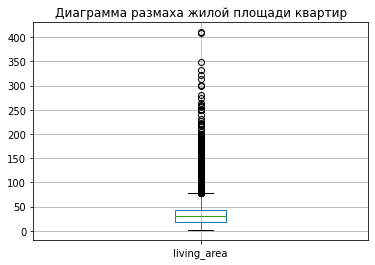

In [26]:
data.boxplot('living_area') #проделываем все также, как и со столбцом общей площади
plt.title('Диаграмма размаха жилой площади квартир');

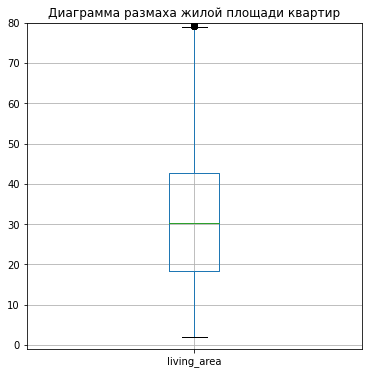

In [27]:
la = data.boxplot('living_area', figsize=(6, 6))
la.set_ylim(-1, 80)
plt.title('Диаграмма размаха жилой площади квартир');

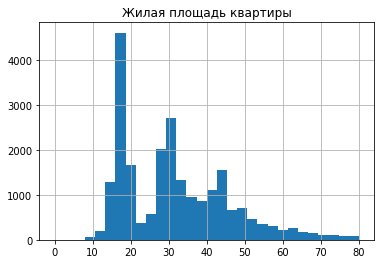

In [28]:
data['living_area'].hist(range=(0, 80), bins=30)
plt.title('Жилая площадь квартиры');

Гистограмма жилой площади имеет более "зубчатый" характер, чем гистограмма общей площади. Медиана жилой плоащди приходится на отметку 30 квадратных метров, однако, превалирующее число обхявлений предлагает квартиры, с жилой площадью около 18 квадратных метров. Далее по количеству объявлений разместились квартиры с жилой площадью окло 29-32 квадратных метров. 

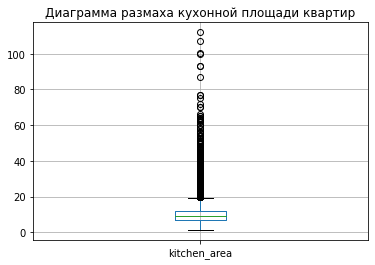

In [29]:
data.boxplot('kitchen_area')
plt.title('Диаграмма размаха кухонной площади квартир');

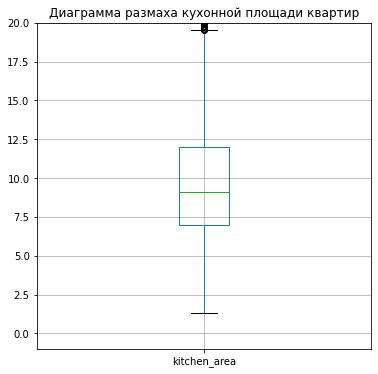

In [30]:
ka = data.boxplot('kitchen_area', figsize=(6, 6))
ka.set_ylim(-1, 20)
plt.title('Диаграмма размаха кухонной площади квартир');

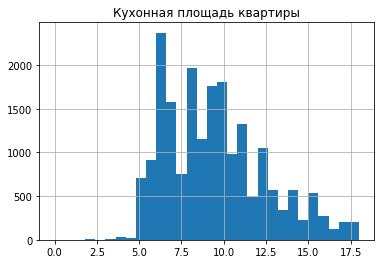

In [31]:
data['kitchen_area'].hist(range=(0, 18), bins=30)
plt.title('Кухонная площадь квартиры');

Пик количества объявлений (более 3000) приходится на кваритры, с площадью кухни около 9 квадратных метров. Около 2400 объявлений предлагают кухню размером 6.5 квадратных метров. Однако, глядя на гистограмму видно, что есть квартиры с осень маленькими кухнями, порядка 2-4 квадратных метра. Также, на просторах объявлений можно найти и просторные кухни, что будет полезно людям, которые любят готовить и имеют множество кухонной утвари, также, в такие просторные кухни можно поставить обеденную зону. 

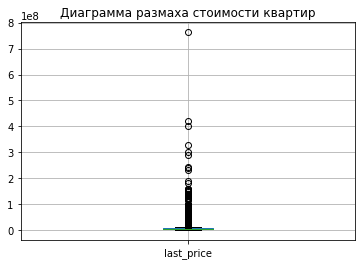

In [32]:
data.boxplot('last_price')
plt.title('Диаграмма размаха стоимости квартир');

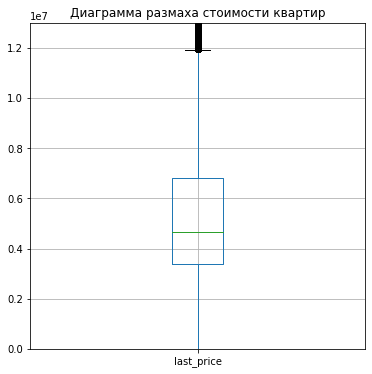

In [33]:
ka = data.boxplot('last_price', figsize=(6, 6))
ka.set_ylim(-1, 1.3e7)
plt.title('Диаграмма размаха стоимости квартир');

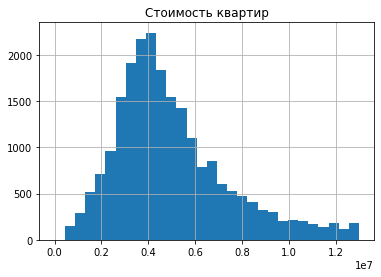

In [34]:
data['last_price'].hist(range=(0, 1.3e7), bins=30)
plt.title('Стоимость квартир');

Пик стоимости квартир приходится на сумму от 3 до 5 миллионов, а половина квартир из объявлений продается по цене 4,5 миллиона. 

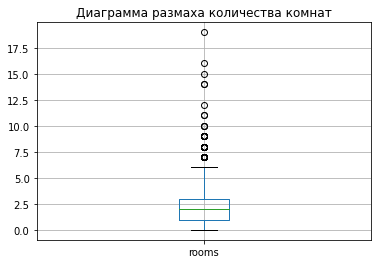

In [35]:
data.boxplot('rooms')
plt.title('Диаграмма размаха количества комнат');

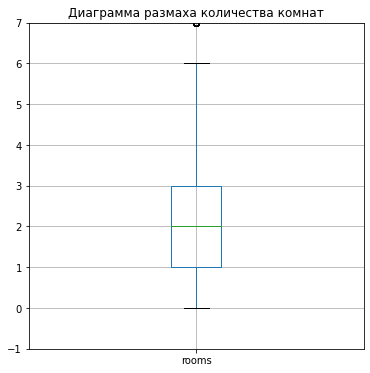

In [36]:
rooms = data.boxplot('rooms', figsize=(6, 6))
rooms.set_ylim(-1, 7)
plt.title('Диаграмма размаха количества комнат');

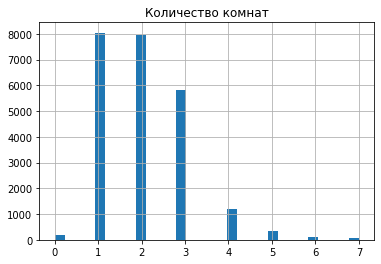

In [37]:
data['rooms'].hist(range=(0, 7), bins=30)
plt.title('Количество комнат');

Медиана представленных объявлений приходится на квартиры с 2-мя комнатами, однако, на гистограмме видно, что примерно такое же количество (8000) квартир продается с 1-ой комнатой. 

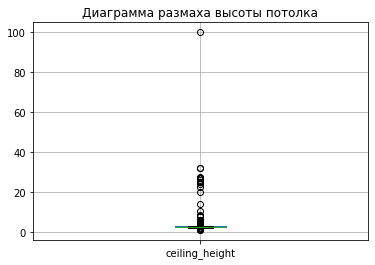

In [38]:
data.boxplot('ceiling_height')
plt.title('Диаграмма размаха высоты потолка');

Видим, что на ящике с усами у нас есть значения, превышающие разумные - 20+м высота потолков, такое вряд ли будет в обычных квартирах на продажу. Предположим, что там есть опечатки - вместо 2.5 м - 25 м. 
Для начала, выведим список уникальных значений для высоты потолка, а затем напишем функцию для возвращения в норму аномально высоких потолков.

In [39]:
print(data['ceiling_height'].unique())

[  2.7     nan   3.03   2.5    2.67   2.56   3.05   2.75   2.6    2.9
   2.8    2.55   3.     2.65   3.2    2.61   3.25   3.45   2.77   2.85
   2.64   2.57   4.15   3.5    3.3    2.71   4.     2.47   2.73   2.84
   3.1    2.34   3.4    3.06   2.72   2.54   2.51   2.78   2.76  25.
   2.58   3.7    2.52   5.2    2.87   2.66   2.59   2.     2.45   3.6
   2.92   3.11   3.13   3.8    3.15   3.55   3.16   3.62   3.12   2.53
   2.74   2.96   2.46   5.3    5.     2.79   2.95   4.06   2.94   3.82
   3.54   3.53   2.83   4.7    2.4    3.38   3.01   5.6    3.65   3.9
   3.18   3.35   2.3    3.57   2.48   2.62   2.82   3.98   2.63   3.83
   3.52   3.95   3.75   2.88   3.67   3.87   3.66   3.85   3.86   4.19
   3.24   4.8    4.5    4.2    3.36  32.     3.08   3.68   3.07   3.37
   3.09   8.     3.26   3.34   2.81   3.44   2.97   3.14   4.37   2.68
   3.22   3.27  27.     4.1    2.93   3.46  24.     3.47   3.33   3.63
   3.32  26.     1.2    8.3    2.98   2.86   3.17   4.4    3.28   3.04
   4.45   5

In [40]:
#пишем функцию для деления на 10 всех значений потолков свыше 20м 
def normal_ceiling(height):
    if height >= 20:  
        return height / 10
    else:
        return height

data['ceiling_height'] = data['ceiling_height'].apply(normal_ceiling)

print(data['ceiling_height'].unique()) #проверяем полученные от применения функции результаты

[ 2.7    nan  3.03  2.5   2.67  2.56  3.05  2.75  2.6   2.9   2.8   2.55
  3.    2.65  3.2   2.61  3.25  3.45  2.77  2.85  2.64  2.57  4.15  3.5
  3.3   2.71  4.    2.47  2.73  2.84  3.1   2.34  3.4   3.06  2.72  2.54
  2.51  2.78  2.76  2.58  3.7   2.52  5.2   2.87  2.66  2.59  2.    2.45
  3.6   2.92  3.11  3.13  3.8   3.15  3.55  3.16  3.62  3.12  2.53  2.74
  2.96  2.46  5.3   5.    2.79  2.95  4.06  2.94  3.82  3.54  3.53  2.83
  4.7   2.4   3.38  3.01  5.6   3.65  3.9   3.18  3.35  2.3   3.57  2.48
  2.62  2.82  3.98  2.63  3.83  3.52  3.95  3.75  2.88  3.67  3.87  3.66
  3.85  3.86  4.19  3.24  4.8   4.5   4.2   3.36  3.08  3.68  3.07  3.37
  3.09  8.    3.26  3.34  2.81  3.44  2.97  3.14  4.37  2.68  3.22  3.27
  4.1   2.93  3.46  3.47  3.33  3.63  3.32  1.2   8.3   2.98  2.86  3.17
  4.4   3.28  3.04  4.45  5.5   3.84  3.23  3.02  3.21  3.43  3.78  4.3
  3.39  2.69  3.31  4.65  3.56  2.2   3.51  3.93  3.42  2.99  3.49 14.
  4.14  2.91  3.88  1.75  4.25  3.29  2.25  3.76  3.69 

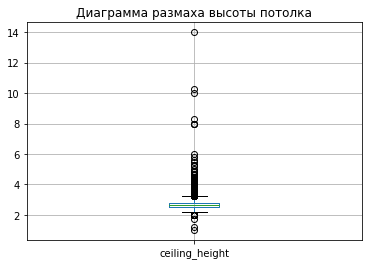

In [41]:
data.boxplot('ceiling_height') #заново строим ящик с усами
plt.title('Диаграмма размаха высоты потолка');

Видно, что выбросы еще присутствуют, однако, это более похоже на правду, поскольку двухуровневые квартиры со "вторым светом" встречаются весьма часто и высота потолков у них считается от пола первого этажа до крыши.

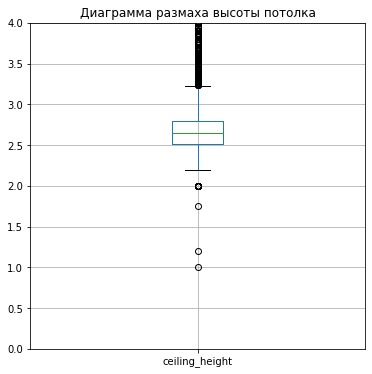

In [42]:
ch = data.boxplot('ceiling_height', figsize=(6, 6))
ch.set_ylim(0, 4)
plt.title('Диаграмма размаха высоты потолка');

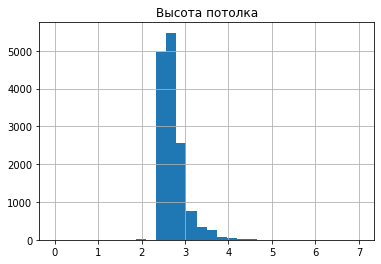

In [43]:
data['ceiling_height'].hist(range=(0, 7), bins=30)
plt.title('Высота потолка');

Наибольшее количество объявлений предлагает купить квартиру с потолками высотой 2.5-2.8 метра, что является стандартной высотой для многих типов домов. 

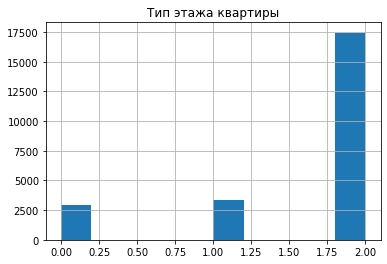

In [44]:
data['floor_group'].hist() #поскольку столбец со словесным описанием столбца типа object и мы его создали сами - строим сразу гистограмму
plt.title('Тип этажа квартиры');

Большинство квартир находится между первым и последним этажом. Наименьшее число квартир продается на первом этаже. Однако, нельзя на все 100% доверять полученным результатам, поскольку в исходных данных присутствует много пропусков в столбце с этажностью дома, который, к сожалению, мы никак не можем воспроизвести, поскольку в 21 веке существуют дома самой различной этажности.
Но, в принципе, даже такой результат ожидаемый - не все любят 1 этаж за большу опасность бандитизма, а на последнем этаже может протекать крыша либо иметься трубы общедомовой коммуникации. 

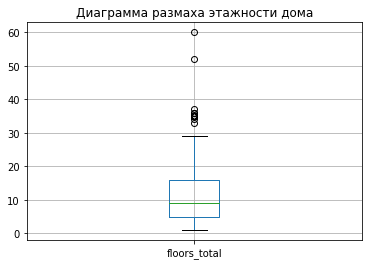

In [45]:
data.boxplot('floors_total')
plt.title('Диаграмма размаха этажности дома');

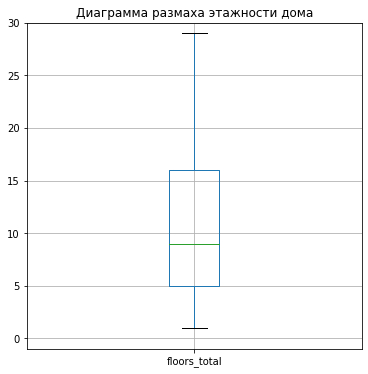

In [46]:
ft = data.boxplot('floors_total', figsize=(6, 6))
ft.set_ylim(-1, 30)
plt.title('Диаграмма размаха этажности дома');

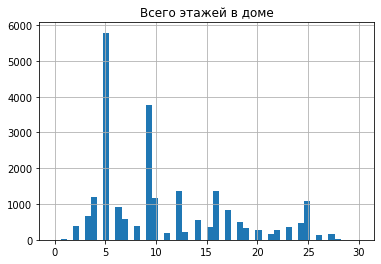

In [47]:
data['floors_total'].hist(range=(0, 30), bins=50)
plt.title('Всего этажей в доме');

По данным гистограммы, большинство объявлений предлагают купить квартиру в пятиэтажке, чуть меньше объявлений предлагают 9-этажную панельку. Имеются также и более "экзотические" дома с двуми и более 25 этажами. 

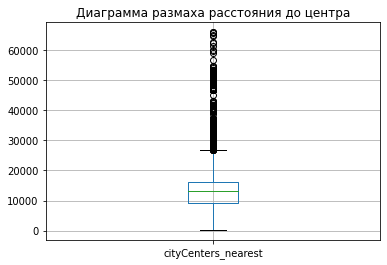

In [48]:
data.boxplot('cityCenters_nearest')
plt.title('Диаграмма размаха расстояния до центра');

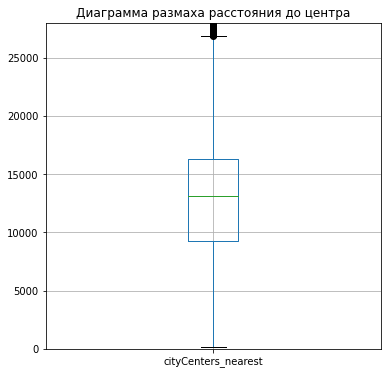

In [49]:
cc = data.boxplot('cityCenters_nearest', figsize=(6, 6))
cc.set_ylim(-1, 28000)
plt.title('Диаграмма размаха расстояния до центра');

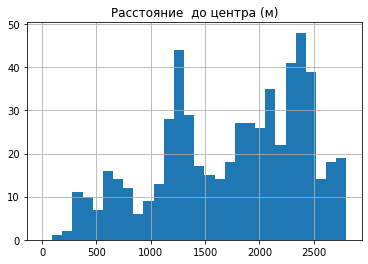

In [50]:
data['cityCenters_nearest'].hist(range=(0, 2800), bins=30)
plt.title('Расстояние  до центра (м)');

Большинство квартир продаются на расстоянии окколо 2.3 км до центра города, есть также большое количество квартир на расстоянии 1.25 км. Намного меньшее число предлагают квартиры прямо в центре города. 

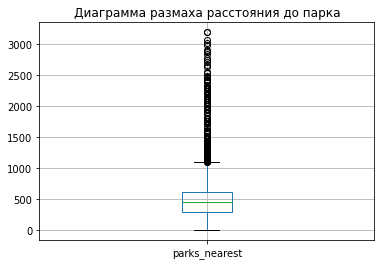

In [51]:
data.boxplot('parks_nearest')
plt.title('Диаграмма размаха расстояния до парка');

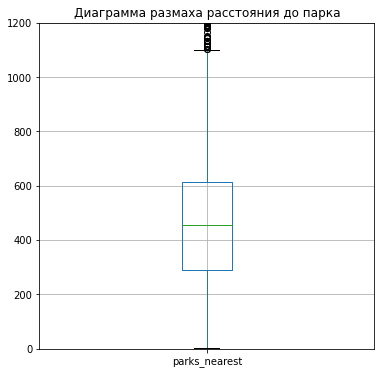

In [52]:
pn = data.boxplot('parks_nearest', figsize=(6, 6))
pn.set_ylim(-1, 1200)
plt.title('Диаграмма размаха расстояния до парка');

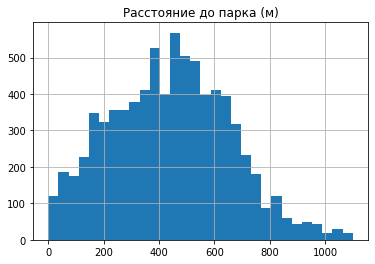

In [53]:
data['parks_nearest'].hist(range=(0, 1100), bins=30)
plt.title('Расстояние до парка (м)');

Ситуация с парками весьма приятная - множество квартир имеют парк буквально в шаговой доступности.

Далее проведем анализ времени продажи квартир, а также найдем самые быстропродаваемые квартиры и те объявления, которые могут висеть на сайте годами. 

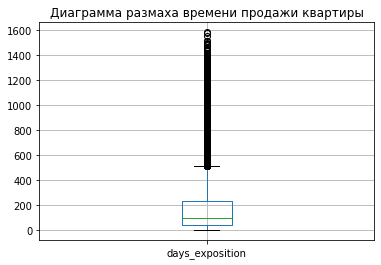

In [54]:
data.boxplot('days_exposition') #строим диаграмму размаха времени продажи квартиры
plt.title('Диаграмма размаха времени продажи квартиры');

Рассмотрим диаграмму размаха времени продажи квартиры. Выбросами на данном графике будут являться те обяъвления, которые висят на сайте более 500 дней. 

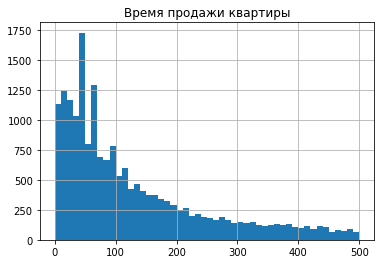

In [55]:
data['days_exposition'].hist(bins=50, range=(0,500)) #строим гистограмму времени продажи квартиры не учитывая выбросы
plt.title('Время продажи квартиры');

In [56]:
data['days_exposition'].describe() #вызываем описательную статистику

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

На построенной гистограмме без учета выбросов видно, что большинство квартир покупается в срок около 50 дне. Затем, после нахождения объявления на площадке более 100 дней количество сделок постепенно уменьшается. Почему квартиры могут так долго висеть на доске объявлений? Вариантов много: необоснованно высокая цена, рассчитанная на людей с очень высоким достатком, отсутствие ремонта, неподходящий малонаселенный город, который не пользуется популярностью, неправильно указанные контактные данные продавца, не позволяющие связаться с ним для приобритения недвижимости и тд.

Просмотрев гистограмму и описательную статистику по срокам продажи квартиры видно, что среднее время продажи квартиры - 180 дней. Медиана продаж квартиры равняется 95 дням. Также, в датафрейме есть и квартиры, которые продавались как день, так и 4 года. Необычайно быстрыми можно считать продажи, находящиеся до Q1: от 1 до 45 дней. Сверхдолгими, в свою очередь, являются квартиры, объявления которых попадают свыше Q3: от 232 до 1580 дней.

Следующим этапом у нас будет поиск факторов, которые больше всего влияют на общую стоимость объекта.

In [57]:
columns = ['last_price', 'living_area', 'total_area', 'kitchen_area', 'rooms']
data_filtr = data[columns].copy()
print(data_filtr.head(5)) #создаем фильтрованную таблицу со столбцами, для которых будем искать связь по цене

   last_price  living_area  total_area  kitchen_area  rooms
0  13000000.0         51.0       108.0          25.0      3
1   3350000.0         18.6        40.4          11.0      1
2   5196000.0         34.3        56.0           8.3      2
3  64900000.0         45.0       159.0           NaN      3
4  10000000.0         32.0       100.0          41.0      2


In [58]:
data_filtr.corr() #находим корелляцию по фильтрованной таблице

,last_price,living_area,total_area,kitchen_area,rooms
last_price,1.000000,0.556066,0.653675,0.519869,0.363343
living_area,0.556066,1.000000,0.909446,0.423638,0.852852
total_area,0.653675,0.909446,1.000000,0.609121,0.758344
kitchen_area,0.519869,0.423638,0.609121,1.000000,0.269945
rooms,0.363343,0.852852,0.758344,0.269945,1.000000


По результам корреляции можем сделать вывод, что имеется корелляция между ценой и общей площадью (коэффициент 0,65), также, более слабая связь наблюдается между ценой и жилой площадью и кухней. 

Построим для большей наглядности графики зависимости цены от вышеперечисленных факторов

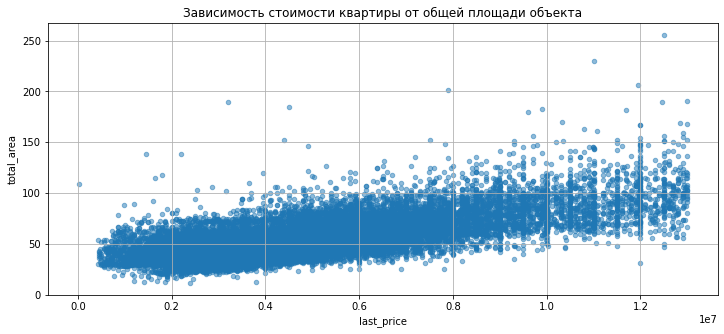

In [59]:
(
    data.query('last_price < 1.3e7')
    .plot.scatter(x='last_price', y='total_area', grid=True, figsize=(12, 5), alpha=0.5)
)
plt.title('Зависимость стоимости квартиры от общей площади объекта');

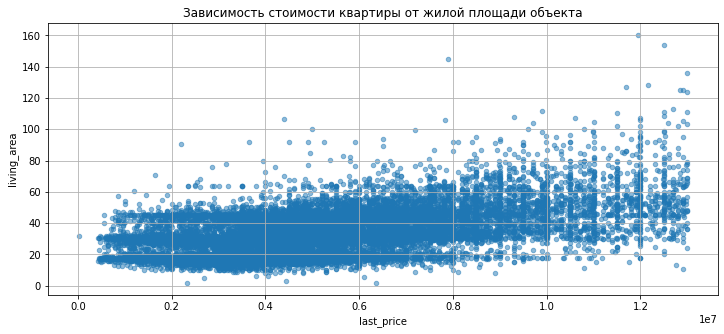

In [60]:
(
    data.query('last_price < 1.3e7')
    .plot.scatter(x='last_price', y='living_area', grid=True, figsize=(12, 5), alpha=0.5)
)
plt.title('Зависимость стоимости квартиры от жилой площади объекта');

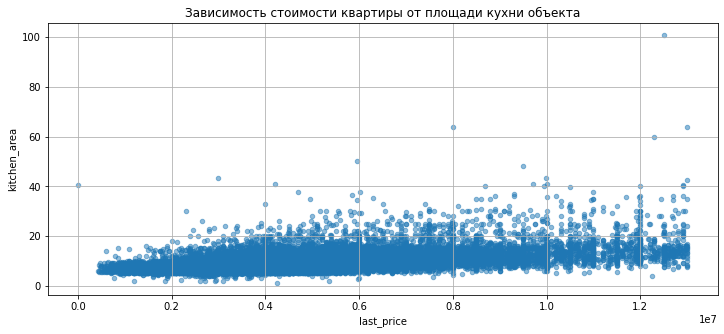

In [61]:
(
    data.query('last_price < 1.3e7')
    .plot.scatter(x='last_price', y='kitchen_area', grid=True, figsize=(12, 5), alpha=0.5)
)
plt.title('Зависимость стоимости квартиры от площади кухни объекта');

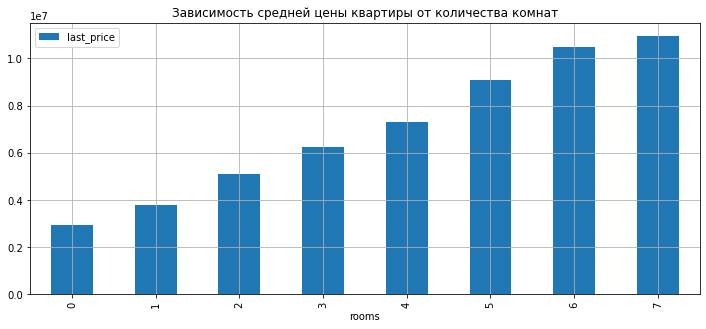

In [62]:
room = (
    data.query('last_price < 1.3e7')
    .groupby('rooms')['last_price'].mean()
    .reset_index()
) 

room.plot(x='rooms', y='last_price', kind='bar', grid=True, figsize=(12, 5))
plt.title('Зависимость средней цены квартиры от количества комнат');

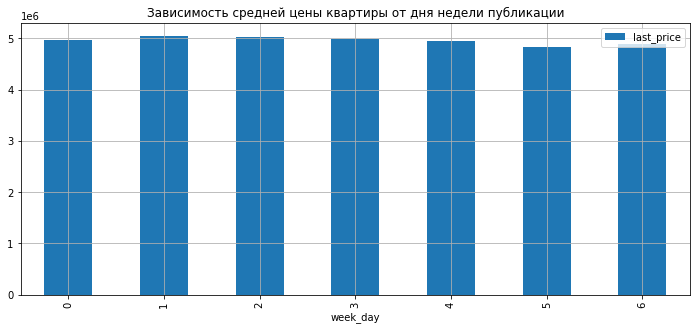

In [63]:
#поскольку тип графика 'bar' и не сможет отобразить большой массив, необходимо сгруппировать данные по цене - посчитаем среднее по дню публикации
day = (
    data.query('last_price < 1.3e7')
    .groupby('week_day')['last_price'].mean()
    .reset_index()
) 

day.plot(x='week_day', y='last_price', kind='bar', grid=True, figsize=(12, 5))
plt.title('Зависимость средней цены квартиры от дня недели публикации');


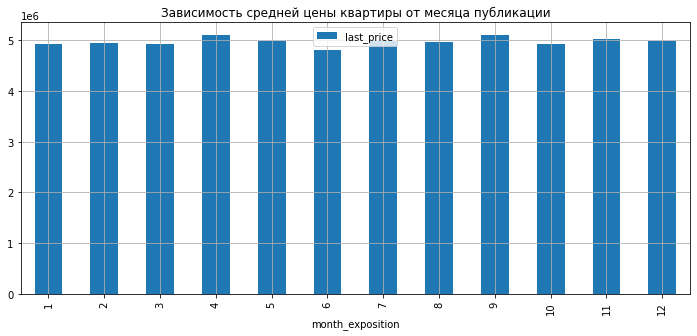

In [64]:
month = (
    data.query('last_price < 1.3e7')
    .groupby('month_exposition')['last_price'].mean()
    .reset_index()
) 

month.plot(x='month_exposition', y='last_price', kind='bar', grid=True, figsize=(12, 5))
plt.title('Зависимость средней цены квартиры от месяца публикации');

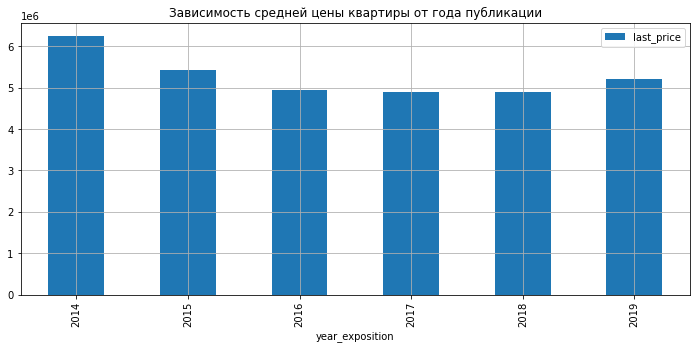

In [65]:
year = (
    data.query('last_price < 1.3e7')
    .groupby('year_exposition')['last_price'].mean()
    .reset_index()
) 

year.plot(x='year_exposition', y='last_price', kind='bar', grid=True, figsize=(12, 5))
plt.title('Зависимость средней цены квартиры от года публикации');

Построенные графики зависимости подтверждают результаты корреляции - на графиках просматривается небольшая зависимость увеличения стоимости квартиры от увеличения площадей. Что логично, поскольку стоимость квартиры в основном рассчитывается по стоимости 1 квадратного метра, независимо от принадлежности этой площади к категориям жилая/нежилая. Единственное, если квартира новая, то застройщик может предложить сниженный коэффициент оплаты по нежелым площадям. Как правило, обычные продавцы вторичного жилья ориентируются на среднюю стоимость квадратного метра по рынку. Также, стоимость может еще зависить от наличия ремонта в квартире. Как правило, квартиры с черновым ремонтом имееют более низкую стоимость квадратного метра относительно квартир с дизайнерским ремонтом. 
    Анализ зависимости стоимости квартиры от дня недели и месяца публикации не показал каких-либо результатов. Квартиры продаются примерно одинаково, независимо от того, когда было опубликовано объявление.
    А вот расмотрение года публикации показало, что после 2014 года стоимость квартиры начала уменьшаться. Скорее всего, это связано с волнениями экономического характера (скачки курса валюты). Но, в 2019 наблюдается небольшой рост.

А теперь изучим населенные пункты с самым многочисленным числом объявлений о продаже недвижимости, посчитаем среднуюю стоимость квадратного метра по этим поселениям и найдем максимальную и минимальную среднюю стоимость квадратного метра.

In [66]:
data_metr = data.pivot_table(index='name_delite_prefix', values='metr_price') #создаем сводную таблицу с названием города и стомостью квадратного метра
adt = data.groupby('name_delite_prefix').size().reset_index(name='count_adt') #группируем таблицу по городу и добавляем столбец с кол-вом объявлений
adt_10 = adt.sort_values(by='count_adt', ascending=False).head(10) #сортируем по убыванию кол-во объявлений и оставляем только 10 строк с городами с максимальным кол-вом объявлений
adt_stat = data[data['name_delite_prefix'].isin(adt_10['name_delite_prefix'])] \
.pivot_table(index='name_delite_prefix', values='metr_price', aggfunc=['mean', 'count']) #строим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов

print(adt_stat, adt_stat.describe()) #выводим на экран таблицу и описательную статистику

                             mean      count
                       metr_price metr_price
name_delite_prefix                          
Всеволожск           68654.473970        398
Выборг               58141.909325        237
Гатчина              68746.146515        307
Колпино              75424.579112        338
Кудрово              95324.930508        472
Мурино               86087.512017        590
Парголово            90175.913089        327
Пушкин              103125.819377        369
Санкт-Петербург     114849.008793      15721
Шушары               78677.364318        440                 mean        count
          metr_price   metr_price
count      10.000000     10.00000
mean    83920.765702   1919.90000
std     17406.332029   4850.20413
min     58141.909325    237.00000
25%     70415.754664    329.75000
50%     82382.438168    383.50000
75%     94037.676154    464.00000
max    114849.008793  15721.00000


Максимальное количество объявлений (15721) приходится на Санк-Петерубрг, также, там и самая высокая средняя стоимость квадратного метра (114849.008794). Из этих топ-10 городов по количеству объявлений минимальную среднюю стоимость квадратного метра имеет Выборг (58141.909153). Также, Выборг имеет и меньшее количество объявлений (237) в данной таблице.

Следом, посмотрим как влияет расстояние до центра города в километрах на среднуюю стоимость квадратного метра в Санк-Петербурге. 

cityCenters_km
0.0     245833.530370
1.0     177005.407604
2.0     157849.007290
3.0     121387.453743
4.0     133282.874738
5.0     140509.789022
6.0     151012.193673
7.0     156176.879524
8.0     125671.442864
9.0     113131.041939
10.0    112727.516968
11.0    108630.835357
12.0    107488.734106
13.0    108148.127893
14.0    104252.384949
15.0    104231.976231
16.0    100542.613929
17.0     96597.652288
18.0     96362.263870
19.0     98652.735732
20.0    103045.181837
21.0     94469.584444
22.0     91330.425099
23.0     91828.517765
24.0     85736.904615
25.0     91531.371154
26.0     89285.877170
27.0    132115.710000
28.0     81161.914286
29.0     72953.365000
Name: metr_price, dtype: float64


<AxesSubplot:xlabel='cityCenters_km'>

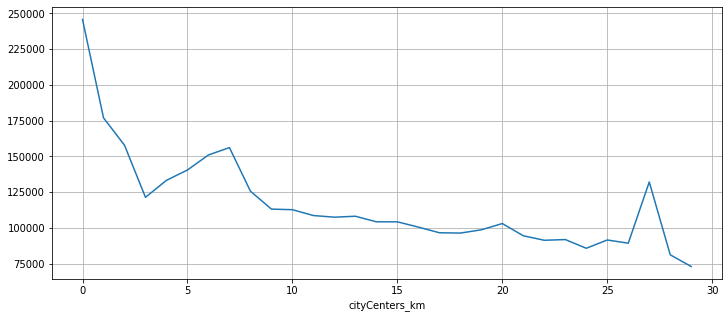

In [67]:
spb = data[data['locality_name'] == 'Санкт-Петербург'] #создаем таблицу только с данными по Санкт-Петербургу
spb_center = spb.groupby('cityCenters_km')['metr_price'].mean() #группируем таблицу по километрам до центра и вычисляем среднюю цену квадратного метра
print(spb_center) #выводим на экран полученные данные после групировки 
spb_center.plot(grid=True, figsize=(12, 5)) #строим график зависимости средней цены за квадратный метр от близости центра города

Ожидаемо, самая большая стоимость квадратного метра принадлежит объявлениям, чьи квартиры находятся прямо в центре города. Затем наблюдается снижение средней стоимости квадратного метра при удалении квартиры от центра города. Однако, на графике видны два пика на 7-ом и 27-ом удалении от центра. Такие пики могут быть обусловлены выбросами - более дорогими квартирами на это участке относительно остальных. Это не обязательно может быть ошибка - возможно, эти дорогие квартиры имеют обоснованную высокую стоимость - новое жилье, дизайнерский ремонт, мебель, входящая в стоимость либо же наличие рядом других достопримечательностей, парков, водоемов. 

### Общие выводы

Таким образом, данный проект был выполнен в несколько этапах.
На этапе предобработки данных была получена таблица и общая информация по ней, найдены и устранены (там, где возможно) пропуски, изменен тип данных для более детального анализа, устранены неявные дубликаты в названиях населенных пунктов. 
Слудеющий этап представлял собой добавление в таблицу новых столбцов со значениями стоимости одного квадратног метра, поделены квартиры по типу этажа (первый, последний, другой), определены колонки со днем, месяцем и годом публикации объявлений, а также добавлена информация о расстоянии до центра города в километрах.
Самый многочисленный этап - исследовательский анализ данных. Во время провения этого этапа выяснено, что большинство продаваемых квартир имеют либо 1, либо две комнаты, располагаются в 5-ти или 9-ти этажных домах с потолками 2,5 метра и не на первом и не на последнем этаже дома. Проводился анализ зависимости стоимости квартиры по разным показателем и обнаружена вполне логичная взаимосвязь между стоимостью и общей площадью квартиры. 
А такие параметры как день недели, месяц и год публикации не влияют на стоиость объекта недвижимости. 
Санк-Петербург из всего датафрейма имеет большее количество объявлений и самую большую среднюю стоимость квадратного метра (114849). В топ-10 городов по количеству объявлений также вошли следующие населенные пункты - Всеволожск, Выборг, Гатчина, Колпино, Кудрово, Мурино, Парголово, Пушкин, Шушары. Из этого списка самую низкую среднюю стоимость квадратного метра имеет Выборг (58142). 
Анализируя Санкт-Петерург была обнаружена взаимосвязь между стоимостью квартиры и дальностью от центра города к илометрах. Это вполне очевидное открытие, поскольку объекты, находящиеся в центре, а особенно в центре такого историческо-кульутрного города как Петербург, всегда будут высоки в цене.
Таким образом, в представленной таблице имеются квартиры на любой бюджет, для семей самых различных размеров. Также можно выбрать квартиры как в центре города, так и поближе к паркам и водоемам.